In [13]:
import scipy.io as scio
import matplotlib.pyplot as plt
data = scio.loadmat('C:/Users/Brilliant/Desktop/data.mat')
matrix_data = data['data']
# 提取第一行（第一通道的EEG数据）
first_channel = matrix_data[0, :]
sampled_data = first_channel[:50000:10]
len(sampled_data)

5000

In [14]:
len(sampled_data)

5000

Epoch 1/100
148/148 [==============================] - 32s 199ms/step - loss: 0.8054
Epoch 2/100
148/148 [==============================] - 33s 226ms/step - loss: 0.6439
Epoch 3/100
148/148 [==============================] - 34s 228ms/step - loss: 0.6055
Epoch 4/100
148/148 [==============================] - 34s 229ms/step - loss: 0.5543
Epoch 5/100
148/148 [==============================] - 36s 246ms/step - loss: 0.5204
Epoch 6/100
148/148 [==============================] - 35s 237ms/step - loss: 0.5100
Epoch 7/100
148/148 [==============================] - 34s 228ms/step - loss: 0.5030
Epoch 8/100
148/148 [==============================] - 34s 232ms/step - loss: 0.4808
Epoch 9/100
148/148 [==============================] - 34s 229ms/step - loss: 0.4744
Epoch 10/100
148/148 [==============================] - 34s 228ms/step - loss: 0.4745
Epoch 11/100
148/148 [==============================] - 34s 228ms/step - loss: 0.4637
Epoch 12/100
148/148 [==============================] - 33s 225

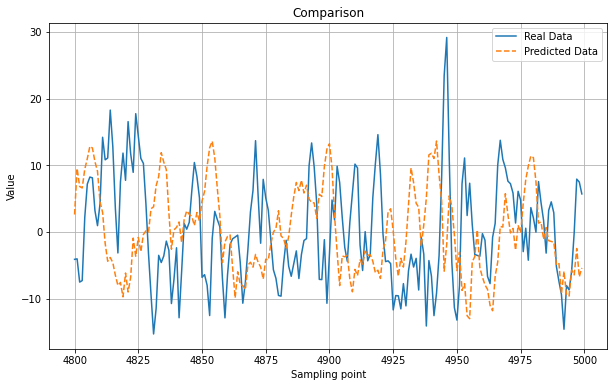

频谱相似度: 0.7250


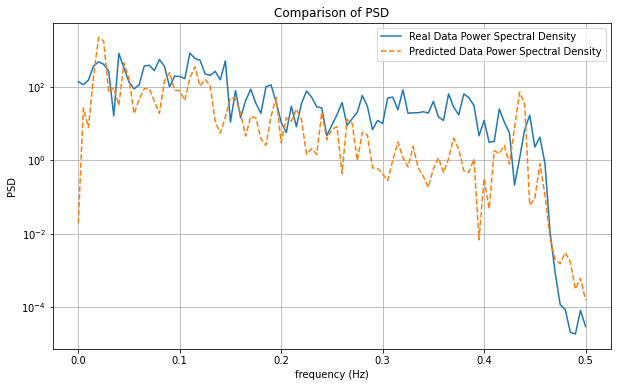

功率谱密度 (PSD) 相似度: 0.4603


In [5]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Input, GRU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from scipy.signal import welch
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 数据标准化
scaler = StandardScaler()  
sampled_data = sampled_data[:5000]
train_data = scaler.fit_transform(sampled_data[:4800].reshape(-1, 1)).reshape(-1)
test_data = scaler.transform(sampled_data[4800:].reshape(-1, 1)).reshape(-1)

n_steps = 90  # 增加时间步长
X, y = [], []

for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i+n_steps])
    y.append(train_data[i+n_steps])

X, y = np.array(X), np.array(y)

# 构建 GRU 模型，增加了一层 GRU
def build_gru_model(input_shape, units, dropout=0):
    inputs = Input(shape=input_shape)
    x = GRU(units, return_sequences=True)(inputs)  # 第一层 GRU，return_sequences=True
    x = GRU(units)(x)  # 第二层 GRU
    x = BatchNormalization()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(1)(x)
    model = Model(inputs, x)
    return model

# 自定义损失函数结合频谱相似度
def custom_loss(y_true, y_pred):
    mse_loss = K.mean(K.square(y_pred - y_true))  # MSE
    fft_true = tf.signal.fft(tf.cast(y_true, tf.complex64))
    fft_pred = tf.signal.fft(tf.cast(y_pred, tf.complex64))
    fft_true_abs = tf.abs(fft_true)
    fft_pred_abs = tf.abs(fft_pred)
    spectral_loss = K.mean(K.square(fft_true_abs - fft_pred_abs))
    return mse_loss + 0.05 * spectral_loss  # 结合 MSE 和频谱相似度

# 构建模型
model = build_gru_model((n_steps, 1), units=256, dropout=0.2)

# 使用自适应学习率调度器
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0005, decay_steps=10000, decay_rate=0.9)

optimizer = Adam(learning_rate=lr_schedule)  # 直接将调度器传递给优化器

# 编译模型
model.compile(optimizer=optimizer, loss=custom_loss)

# 学习率调度器和早停机制
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6)

# 模型训练
epochs = 100
X = X.reshape((X.shape[0], X.shape[1], 1))  # 调整为 GRU 输入格式
model.fit(X, y, epochs=epochs, batch_size=32, shuffle=False, verbose=1, callbacks=[early_stopping])

# 用模型预测未来 200 个点
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))  # 取最后 90 个点作为输入
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    # 检查预测值是否异常，避免 NaN 或 inf
    if np.isnan(predicted).any() or np.isinf(predicted).any():
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0  # 处理异常值

    predicted_points.append(predicted[0][0])

    # 滑动窗口更新
    predicted_reshaped = np.array(predicted[0][0]).reshape(1, 1, 1)
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)  # 将预测结果转换为 NumPy 数组

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1)).reshape(-1)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Predicted Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)

fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD)
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)  # Welch 方法计算真实数据的功率谱密度
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)  # 计算预测数据的功率谱密度

plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real Data Power Spectral Density')
plt.semilogy(f_pred, psd_pred, label='Predicted Data Power Spectral Density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')


Epoch 1/100
118/118 [==============================] - ETA: 0s - loss: 4.2249
Epoch 1: val_loss improved from inf to 3.29269, saving model to best_model.h5
118/118 [==============================] - 24s 170ms/step - loss: 4.2249 - val_loss: 3.2927
Epoch 2/100
118/118 [==============================] - ETA: 0s - loss: 2.7166
Epoch 2: val_loss improved from 3.29269 to 2.65807, saving model to best_model.h5
118/118 [==============================] - 21s 175ms/step - loss: 2.7166 - val_loss: 2.6581
Epoch 3/100
118/118 [==============================] - ETA: 0s - loss: 2.2688
Epoch 3: val_loss improved from 2.65807 to 2.37657, saving model to best_model.h5
118/118 [==============================] - 20s 171ms/step - loss: 2.2688 - val_loss: 2.3766
Epoch 4/100
118/118 [==============================] - ETA: 0s - loss: 2.0418
Epoch 4: val_loss improved from 2.37657 to 2.07353, saving model to best_model.h5
118/118 [==============================] - 20s 172ms/step - loss: 2.0418 - val_loss: 2.0

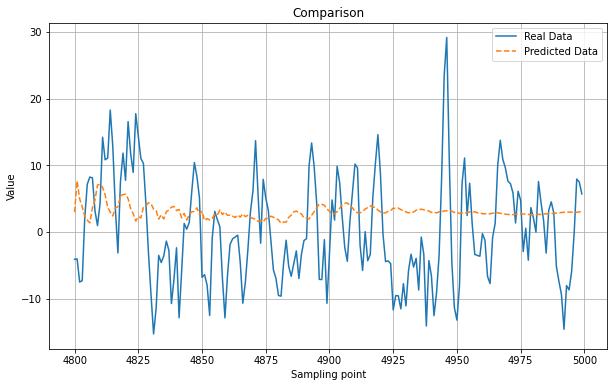

频谱相似度: 0.2386


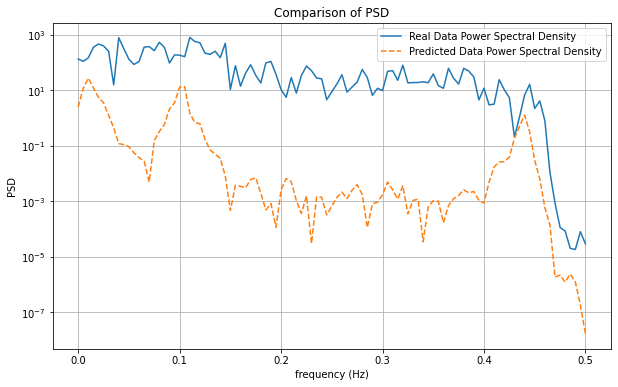

功率谱密度 (PSD) 相似度: 0.2937


In [19]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Input, GRU, Dropout
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from scipy.signal import welch
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 数据标准化
scaler = StandardScaler()  
sampled_data = sampled_data[:5000]
train_data = scaler.fit_transform(sampled_data[:4800].reshape(-1, 1)).reshape(-1)
test_data = scaler.transform(sampled_data[4800:].reshape(-1, 1)).reshape(-1)

n_steps = 90  # 增加时间步长
X, y = [], []

for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i+n_steps])
    y.append(train_data[i+n_steps])

X, y = np.array(X), np.array(y)

# 构建 GRU 模型，增加一层 GRU 并添加 L2 正则化
def build_gru_model(input_shape, units, dropout=0, l2_reg=0.01):
    inputs = Input(shape=input_shape)
    x = GRU(units, return_sequences=True, kernel_regularizer=l2(l2_reg))(inputs)  # 第一层 GRU，带 L2 正则化
    x = GRU(units, return_sequences=True, kernel_regularizer=l2(l2_reg))(x)       # 第二层 GRU，带 L2 正则化
    x = GRU(units, kernel_regularizer=l2(l2_reg))(x)                              # 第三层 GRU，带 L2 正则化
    x = BatchNormalization()(x)
    x = Dense(64, activation="relu", kernel_regularizer=l2(l2_reg))(x)            # Dense 层，带 L2 正则化
    x = Dropout(dropout)(x)
    x = Dense(1, kernel_regularizer=l2(l2_reg))(x)                                # 输出层，带 L2 正则化
    model = Model(inputs, x)
    return model

# 自定义损失函数结合频谱相似度
def custom_loss(y_true, y_pred):
    mse_loss = K.mean(K.square(y_pred - y_true))  # MSE
    fft_true = tf.signal.fft(tf.cast(y_true, tf.complex64))
    fft_pred = tf.signal.fft(tf.cast(y_pred, tf.complex64))
    fft_true_abs = tf.abs(fft_true)
    fft_pred_abs = tf.abs(fft_pred)
    spectral_loss = K.mean(K.square(fft_true_abs - fft_pred_abs))
    return mse_loss + 0.1 * spectral_loss  # 结合 MSE 和频谱相似度

# 构建模型
model = build_gru_model((n_steps, 1), units=128, dropout=0.3, l2_reg=0.01)

# 使用自适应学习率调度器
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0005, decay_steps=5000, decay_rate=0.95)

optimizer = Adam(learning_rate=lr_schedule)  # 使用 Nadam 优化器

# 编译模型
model.compile(optimizer=optimizer, loss=custom_loss)

# 学习率调度器和早停机制
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.h5',   # 保存模型的路径
    monitor='val_loss',         # 监控验证损失
    save_best_only=True,        # 仅保存验证集上表现最好的模型
    mode='min',                 # 寻找最小的 val_loss
    verbose=1                   # 每次保存时打印提示
)

# 模型训练
epochs = 100
X = X.reshape((X.shape[0], X.shape[1], 1))  # 调整为 GRU 输入格式
history = model.fit(
    X, y, 
    validation_split=0.2,       # 使用 20% 的数据作为验证集
    epochs=epochs, 
    batch_size=32, 
    shuffle=False, 
    verbose=1, 
    callbacks=[early_stopping, checkpoint_callback]
)

# 用模型预测未来 200 个点
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))  # 取最后 90 个点作为输入
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    # 检查预测值是否异常，避免 NaN 或 inf
    if np.isnan(predicted).any() or np.isinf(predicted).any():
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0  # 处理异常值

    predicted_points.append(predicted[0][0])

    # 滑动窗口更新
    predicted_reshaped = np.array(predicted[0][0]).reshape(1, 1, 1)
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)  # 将预测结果转换为 NumPy 数组

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1)).reshape(-1)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Predicted Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)

fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD)
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)  # Welch 方法计算真实数据的功率谱密度
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)  # 计算预测数据的功率谱密度

plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real Data Power Spectral Density')
plt.semilogy(f_pred, psd_pred, label='Predicted Data Power Spectral Density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')


Epoch 1/100
118/118 [==============================] - ETA: 0s - loss: 4.2917
Epoch 1: val_loss improved from inf to 3.38315, saving model to best_model.h5

Epoch 1: Learning rate is 0.000500
118/118 [==============================] - 48s 299ms/step - loss: 4.2917 - val_loss: 3.3831
Epoch 2/100
118/118 [==============================] - ETA: 0s - loss: 2.7695
Epoch 2: val_loss improved from 3.38315 to 2.72279, saving model to best_model.h5

Epoch 2: Learning rate is 0.000500
118/118 [==============================] - 33s 280ms/step - loss: 2.7695 - val_loss: 2.7228
Epoch 3/100
118/118 [==============================] - ETA: 0s - loss: 2.2938
Epoch 3: val_loss improved from 2.72279 to 2.43425, saving model to best_model.h5

Epoch 3: Learning rate is 0.000500
118/118 [==============================] - 27s 225ms/step - loss: 2.2938 - val_loss: 2.4342
Epoch 4/100
118/118 [==============================] - ETA: 0s - loss: 2.0499
Epoch 4: val_loss improved from 2.43425 to 2.16468, saving mod

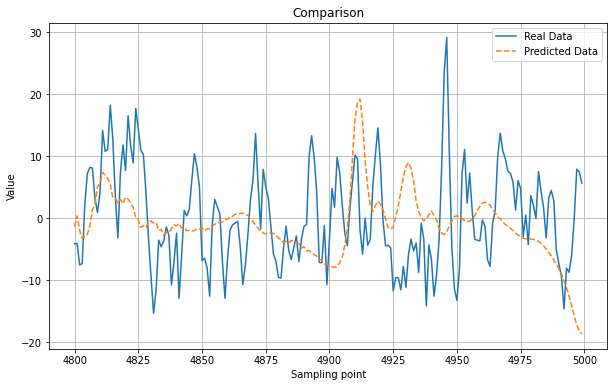

频谱相似度: 0.7474


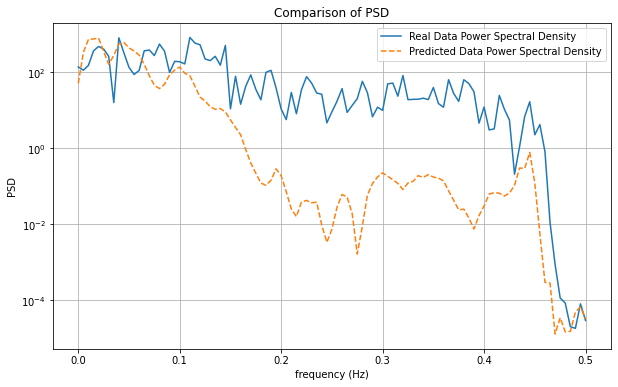

功率谱密度 (PSD) 相似度: 0.5696


In [11]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Input, GRU, Dropout
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from scipy.signal import welch
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 数据标准化
scaler = StandardScaler()  
sampled_data = sampled_data[:5000]
train_data = scaler.fit_transform(sampled_data[:4800].reshape(-1, 1)).reshape(-1)
test_data = scaler.transform(sampled_data[4800:].reshape(-1, 1)).reshape(-1)

n_steps = 90  # 增加时间步长
X, y = [], []

for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i+n_steps])
    y.append(train_data[i+n_steps])

X, y = np.array(X), np.array(y)

# 构建 GRU 模型，增加一层 GRU 并添加 L2 正则化
def build_gru_model(input_shape, units, dropout=0, l2_reg=0.01):
    inputs = Input(shape=input_shape)
    x = GRU(units, return_sequences=True, kernel_regularizer=l2(l2_reg))(inputs)  # 第一层 GRU，带 L2 正则化
    x = GRU(units, return_sequences=True, kernel_regularizer=l2(l2_reg))(x)       # 第二层 GRU，带 L2 正则化
    x = GRU(units, kernel_regularizer=l2(l2_reg))(x)                              # 第三层 GRU，带 L2 正则化
    x = BatchNormalization()(x)
    x = Dense(64, activation="relu", kernel_regularizer=l2(l2_reg))(x)            # Dense 层，带 L2 正则化
    x = Dropout(dropout)(x)
    x = Dense(1, kernel_regularizer=l2(l2_reg))(x)                                # 输出层，带 L2 正则化
    model = Model(inputs, x)
    return model

# 自定义损失函数结合频谱相似度
def custom_loss(y_true, y_pred):
    mse_loss = K.mean(K.square(y_pred - y_true))  # MSE
    fft_true = tf.signal.fft(tf.cast(y_true, tf.complex64))
    fft_pred = tf.signal.fft(tf.cast(y_pred, tf.complex64))
    fft_true_abs = tf.abs(fft_true)
    fft_pred_abs = tf.abs(fft_pred)
    spectral_loss = K.mean(K.square(fft_true_abs - fft_pred_abs))
    return mse_loss + 0.1 * spectral_loss  # 结合 MSE 和频谱相似度

# 构建模型
model = build_gru_model((n_steps, 1), units=128, dropout=0.3, l2_reg=0.01)

# 使用 Nadam 优化器（不直接传入 lr_schedule）
optimizer = Nadam(learning_rate=0.0005)  # 初始学习率为 0.0005

# 编译模型
model.compile(optimizer=optimizer, loss=custom_loss)

# 学习率调度器和早停机制
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.h5',   # 保存模型的路径
    monitor='val_loss',         # 监控验证损失
    save_best_only=True,        # 仅保存验证集上表现最好的模型
    mode='min',                 # 寻找最小的 val_loss
    verbose=1                   # 每次保存时打印提示
)

# 自定义回调，用于手动调整 Nadam 优化器的学习率
def update_learning_rate(epoch, logs):
    new_lr = 0.0005 * (0.95 ** (epoch // 50))  # 每 50 个 epoch 递减
    K.set_value(optimizer.learning_rate, new_lr)
    print(f"\nEpoch {epoch+1}: Learning rate is {new_lr:.6f}")

lr_callback = LambdaCallback(on_epoch_end=update_learning_rate)

# 模型训练
epochs = 100
X = X.reshape((X.shape[0], X.shape[1], 1))  # 调整为 GRU 输入格式
history = model.fit(
    X, y, 
    validation_split=0.2,       # 使用 20% 的数据作为验证集
    epochs=epochs, 
    batch_size=32, 
    shuffle=False, 
    verbose=1, 
    callbacks=[early_stopping, checkpoint_callback, lr_callback]
)

# 用模型预测未来 200 个点
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))  # 取最后 90 个点作为输入
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    # 检查预测值是否异常，避免 NaN 或 inf
    if np.isnan(predicted).any() or np.isinf(predicted).any():
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0  # 处理异常值

    predicted_points.append(predicted[0][0])

    # 滑动窗口更新
    predicted_reshaped = np.array(predicted[0][0]).reshape(1, 1, 1)
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)  # 将预测结果转换为 NumPy 数组

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1)).reshape(-1)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Predicted Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)

fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD)
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)  # Welch 方法计算真实数据的功率谱密度
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)  # 计算预测数据的功率谱密度

plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real Data Power Spectral Density')
plt.semilogy(f_pred, psd_pred, label='Predicted Data Power Spectral Density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')
